<a href="https://www.kaggle.com/code/ravaghi/classifying-tabular-data-with-lightning-mlp?scriptVersionId=167457988" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install -q lightning

In [2]:
import warnings
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import lightning as L
import seaborn as sns
from datetime import datetime
from torch.utils.data import DataLoader, TensorDataset
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from lightning import seed_everything
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

seed_everything(27)
matplotlib.style.use("ggplot")
warnings.filterwarnings('ignore')

INFO: Seed set to 27


# Loading and Visualizing data

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s4e3/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e3/test.csv")

## No Missing values

In [4]:
train.isna().sum()

id                       0
X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
dtype: int64

## Label Distribution

In [5]:
label_cols = [
    "Pastry",
    "Z_Scratch",
    "K_Scatch",
    "Stains",
    "Dirtiness",
    "Bumps",
    "Other_Faults"
]

train["Defect_Type"] = train[label_cols].idxmax(axis=1)

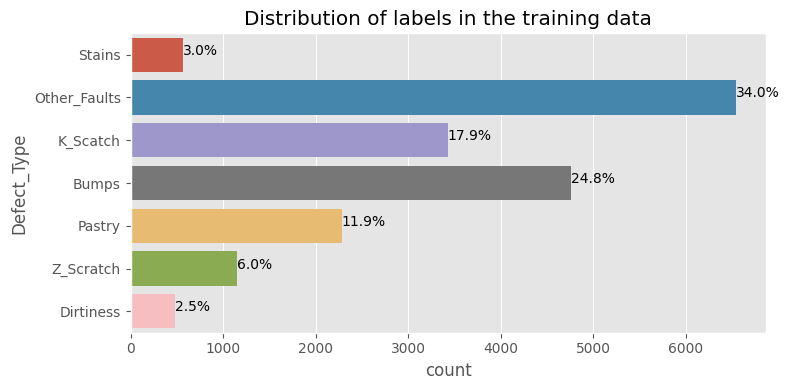

In [6]:
plt.figure(figsize=(8, 4))
ax = sns.countplot(y="Defect_Type", data=train)
plt.title('Distribution of labels in the training data')

total = len(train)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

plt.tight_layout()
plt.show()

# Scaling Features

In [7]:
X = train.drop(["Defect_Type", "id"] + label_cols, axis=1)
y = train[label_cols]
X_test = test.drop("id", axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating Data Module

In [8]:
class SteelDataModule(L.LightningDataModule):
    def __init__(
        self,
        X_train: np.ndarray,
        y_train: pd.DataFrame,
        X_val: np.ndarray,
        y_val: pd.DataFrame,
        batch_size: int
    ):
        super(SteelDataModule, self).__init__()
        self.X_train = torch.tensor(X_train, dtype=torch.float32)
        self.y_train = torch.tensor(y_train.values, dtype=torch.float32)
        self.X_val = torch.tensor(X_val, dtype=torch.float32)
        self.y_val = torch.tensor(y_val.values, dtype=torch.float32)
        self.batch_size = batch_size

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            dataset=TensorDataset(self.X_train, self.y_train),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def val_dataloader(self) -> DataLoader:
        return DataLoader(
            dataset=TensorDataset(self.X_val, self.y_val),
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )

# Defining MLP Model

In [9]:
class MLPModel(L.LightningModule):
    def __init__(self, input_dim, output_dim, batch_size, learning_rate):
        super(MLPModel, self).__init__()
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        self.classifier = nn.Sequential(
            # Layer 1
            nn.Linear(input_dim, 250),
            nn.BatchNorm1d(250),
            nn.Tanh(),
            nn.Dropout(0.45),
            # Layer 2
            nn.Linear(250, 50),
            nn.BatchNorm1d(50),
            nn.Tanh(),
            nn.Dropout(0.15),
            # Layer 3
            nn.Linear(50, 100),
            nn.BatchNorm1d(100),
            nn.Tanh(),
            nn.Dropout(0.05),
            # Output Layer
            nn.Linear(100, output_dim),
            nn.Softmax(dim=1)
        )

        self.histories = {
            "train": {
                "epoch": [],
                "loss": [],
                "auc": []
            },
            "val": {
                "epoch": [],
                "loss": [],
                "auc": []
            }
        }

        self.criterion = nn.BCELoss()
        
        self.current_epoch_train_aucs = []
        self.current_epoch_train_losses = []
        self.current_epoch_val_aucs = []
        self.current_epoch_val_losses = []

    def calcualte_auc(self, y, y_hat):
        y = y.cpu().numpy()
        y_hat = y_hat.cpu().detach().numpy()
        
        scores = []
        for i in range(y.shape[1]):
            try:
                score = roc_auc_score(
                    y_true=y[:, i],
                    y_score=y_hat[:, i],
                    multi_class='ovo',
                    average='weighted'
                )
            except:
                score = 0.5
            scores.append(score)
        return np.mean(scores)

    def forward(self, x):
        return self.classifier(x)

    def shared_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        auc = self.calcualte_auc(y, y_hat)
        return loss, auc

    def log_metrics(self, history_type, loss, auc):
        if history_type == "train":
            self.current_epoch_train_aucs.append(auc)
            self.current_epoch_train_losses.append(loss)
        else:
            self.current_epoch_val_aucs.append(auc)
            self.current_epoch_val_losses.append(loss)
        self.log_dict(
            {
                f"{history_type}_loss": loss,
                f"{history_type}_auc": auc
            },
            on_step=False,
            on_epoch=True,
            prog_bar=True
        )

    def training_step(self, batch, batch_idx):
        loss, auc = self.shared_step(batch, batch_idx)
        self.log_metrics("train", loss.item(), auc)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, auc = self.shared_step(batch, batch_idx)
        self.log_metrics("val", loss.item(), auc)
        return loss
    
    def on_train_epoch_end(self):
        epoch_auc = np.mean(self.current_epoch_train_aucs)
        epoch_loss = np.mean(self.current_epoch_train_losses)
        self.histories["train"]["epoch"].append(self.current_epoch)
        self.histories["train"]["auc"].append(epoch_auc)
        self.histories["train"]["loss"].append(epoch_loss)
        
        self.current_epoch_train_aucs = []
        self.current_epoch_train_losses = []
        
    def on_validation_epoch_end(self):        
        epoch_auc = np.mean(self.current_epoch_val_aucs)
        epoch_loss = np.mean(self.current_epoch_val_losses)
        self.histories["val"]["epoch"].append(self.current_epoch)
        self.histories["val"]["auc"].append(epoch_auc)
        self.histories["val"]["loss"].append(epoch_loss)
        
        self.current_epoch_val_aucs = []
        self.current_epoch_val_losses = []       
        
    def predict(self, x):
        return self(x)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode="max", 
            factor=0.1, 
            patience=9, 
            threshold=0.001,
            verbose=False
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_auc"
            }
        }

# Training

In [10]:
BATCH_SIZE = 256
LEARNING_RATE = 0.0094
MAX_EPOCHS = 100

data_module = SteelDataModule(X_train, y_train, X_val, y_val, BATCH_SIZE)
model = MLPModel(X_train.shape[1], y_train.shape[1], BATCH_SIZE, LEARNING_RATE)

In [11]:
early_stopping = EarlyStopping(
    monitor="val_auc", 
    patience=11, 
    mode="max",                  
    verbose=False, 
    check_on_train_epoch_end=True, 
    min_delta=0.001
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_auc',
    dirpath=f'./checkpoints/{datetime.now().strftime("%Y%m%d-%H%M%S")}',
    filename='{epoch}-{val_auc:.4f}-{val_loss:.4f}',
    auto_insert_metric_name=False,
    save_top_k=3,
    every_n_epochs=1,
    mode='max',
    save_on_train_epoch_end=True
)

trainer = L.Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[early_stopping, checkpoint_callback],
)

INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [12]:
trainer.fit(model, data_module)
trainer.validate(model, data_module)

2024-03-17 13:46:59.563405: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 13:46:59.563522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 13:46:59.714204: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: 
  | Name       | Type       | Params
------------------------------------------
0 | classifier | Sequential | 26.2 K
1 | criterion  | BCELoss    | 0     
------------------------------------------
26.2 K    Trainable params
0         Non-trainable params
26.2 K    Total params
0.105     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_auc          │    0.8805489540100098     │
│         val_loss          │    0.22538457810878754    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.22538457810878754, 'val_auc': 0.8805489540100098}]

# Visualizing the Result

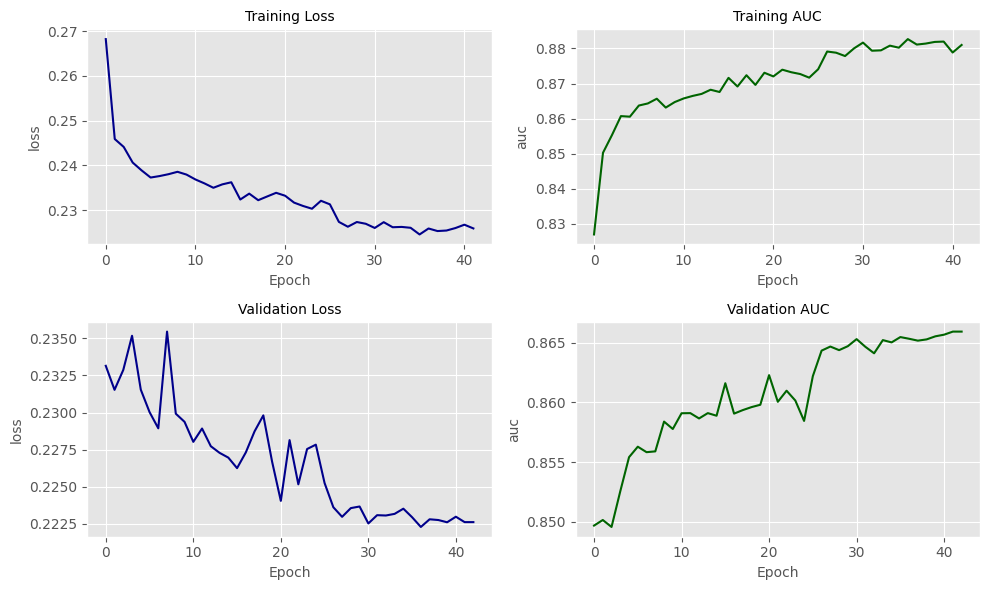

In [13]:
histories = model.histories

if histories["val"]["epoch"][0] == histories["val"]["epoch"][1]:
    histories["val"]["epoch"] = histories["val"]["epoch"][1:]
    histories["val"]["auc"] = histories["val"]["auc"][1:]
    histories["val"]["loss"] = histories["val"]["loss"][1:]

def plot_metric(ax, history, metric, title, color):
    steps = history["epoch"]
    values = pd.Series(history[metric])
    ax.plot(steps, values, color=color)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Epoch", fontsize=10)
    ax.set_ylabel(metric, fontsize=10)

fig, ax = plt.subplots(2, 2, figsize=(10, 6))

plot_metric(ax[0, 0], histories["train"], "loss", "Training Loss", 'darkblue')
plot_metric(ax[0, 1], histories["train"], "auc", "Training AUC", 'darkgreen')
plot_metric(ax[1, 0], histories["val"], "loss", "Validation Loss", 'darkblue')
plot_metric(ax[1, 1], histories["val"], "auc", "Validation AUC", 'darkgreen')

plt.tight_layout()
plt.show()

# Creating Submission

In [14]:
model = MLPModel.load_from_checkpoint(
    checkpoint_callback.best_model_path, 
    input_dim=X_train.shape[1], 
    output_dim=y_train.shape[1], 
    batch_size=BATCH_SIZE, 
    learning_rate=LEARNING_RATE
)

y_hat = model.predict(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()

submission = pd.DataFrame(y_hat, columns=label_cols)
submission["id"] = test["id"]
submission = submission[["id"] + label_cols]
submission.to_csv("submission.csv", index=False)
submission.head()

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.575251,0.001189,0.002680,0.000077,0.049084,0.101566,0.270153
1,19220,0.232685,0.005988,0.017107,0.002749,0.140648,0.173085,0.427739
2,19221,0.003366,0.074914,0.046389,0.002030,0.013691,0.367417,0.492193
3,19222,0.113078,0.003885,0.000725,0.003185,0.021146,0.323318,0.534662
4,19223,0.011146,0.001603,0.004148,0.000253,0.003389,0.600532,0.378928
